# use RI events to predict time since infection

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-10-26 15:35:57.968901
Simons Foundation, Rusty HPC, worker3009


In [2]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import Jemm, JemmLinearRegression
from jemm.covariate import Contrasts, Covariate

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import os
import random

from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
import scipy

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True


%run ./notebook/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
data_files = {
    'SE': {
        'jct': None,
        'txr': './data-V9/compiled/txr_SE.JemmPlainText.txt'
    },
    'A5SS': {
        'jct': None,
        'txr': './data-V7/compiled/txr_A5SS.pkl'
    },
    'A3SS': {
        'jct': None,
        'txr': './data-V7/compiled/txr_A3SS.pkl'
    },
    'RI': {
        'jct': None,
        'txr': './data-V7/compiled/txr_RI.pkl'
    }
}

reg_tables = {
    #'SE': './%s/joint_SE/joint.SE.reg_table.tsv'% DATA_VER,
    'A5SS': './%s/joint_A5SS/joint.A5SS.reg_table.tsv'% DATA_VER,
    'A3SS': './%s/joint_A3SS/joint.A3SS.reg_table.tsv'% DATA_VER,
    'RI': './%s/joint_RI/joint.RI.reg_table.tsv'% DATA_VER
}


contrast_cols = ['final@Pre', 'final@First', 'final@Mid', 'final@Post', 
                 'final@False Negative','final@Immune', 'final@Reinfection',
                 'final@Asymptomatic', 
                 'final@Exposed', 
                 'final@Mild',
                 'final@Moderate']

metaloader = MetaLoader(covs, data_files, reg_tables,
                        jem_type='lmm' if USE_RE else 'lm',
                        jem_kwargs={'diff_intercept_by_measure':True,
                            'group_varname': 'pid'})

loading SE..


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


loading A5SS..


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading A3SS..


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading RI..


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [5]:
txr = {}

for as_type in data_files:
    print(metaloader.data[as_type].transcript_measure.shape)
    txr[as_type] = pd.read_table(f'./data-V9/compiled/txr_{as_type}.txt', index_col=0)
    print(txr[as_type].shape)

(47847, 1176)
(47847, 1548)
(17687, 1176)
(17687, 1548)
(19353, 1176)
(19353, 1548)
(7345, 1176)
(7345, 1548)


In [6]:
meta = pd.read_table('data-V9/charm_master.csv', index_col=0)
inf_pids = meta.loc[meta.query('final=="First" or final=="Mid" or final=="Post"').index].pid.unique()
meta = meta.loc[meta.pid.isin(inf_pids)]

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (9,16,25,55,62,63,64,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
tmp = []
for _, x in meta.groupby('pid'):
    x['inf_tp'] = x['tp'] - x.query('final=="First"')['tp'].mean()
    tmp.append(x)

In [8]:
# make infection df
infect_df = pd.concat(tmp)
infect_df = infect_df[~infect_df.RNAseq_plate.isna()]
infect_df = infect_df[~infect_df.inf_tp.isna()]
infect_df.loc[ infect_df.inf_tp< -20, 'inf_tp'] = -20
#infect_df = infect_df.loc[ infect_df.inf_tp > -20]
#infect_df = infect_df.loc[ infect_df.inf_tp< 30]
infect_df.shape

(1516, 70)

In [9]:
def make_data(sig_eids, infect_df, as_type='RI'):
    n_eids = len(sig_eids)
    das_df = txr[as_type].transpose()[sig_eids]
    das_df = das_df.fillna(das_df.mean())
    infect_df = infect_df.join(das_df)
    return infect_df, n_eids

In [10]:
def train_loocv(inf_df, n_eids):   
    preds = []
    mods = {}
    for pid in tqdm(inf_pids):
        fit_data = inf_df.query(f'pid!="{pid}"')
        test_data = inf_df.query(f'pid=="{pid}"')
        if not len(test_data):
            continue
        fit_x = fit_data.iloc[:, -n_eids:]
        fit_y = fit_data['inf_tp']
        fit_x = fit_x.fillna(fit_x.mean())
        #mod = ElasticNet(alpha=100).fit(fit_x, fit_y)
        #mod = LinearRegression().fit(fit_x, fit_y)
        #mod = Ridge(alpha=0.2).fit(fit_x, fit_y)
        mod = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(fit_x, fit_y)
        mods[pid] = mod
        test_x = test_data.iloc[:, -n_eids:]
        test_x = test_x.fillna(test_x.mean()).fillna(test_x.mean().mean())
        test_info = test_data[['pid', 'Sex', 'inf_tp', 'T0_date', 'tp',
                                       'paxgene_date', 'RNAseq_plate', 
                                      'final']]
        test_info['pred_tp'] = mod.predict(test_x)
        preds.append(test_info)
    
    pred_df = pd.concat(preds)
    print(scipy.stats.spearmanr(pred_df.pred_tp, pred_df.inf_tp))
    print(scipy.stats.pearsonr(pred_df.pred_tp, pred_df.inf_tp))

    sns.set_style('whitegrid')
    sns.regplot(x='inf_tp', y='pred_tp', data=pred_df, lowess=True, scatter_kws={'color':'black', 'alpha':0.2})
    return pred_df, mods
    

100%|██████████| 1244/1244 [13:30<00:00,  1.54it/s]


SpearmanrResult(correlation=0.46731374670709075, pvalue=4.3450579604487774e-83)
(0.4481972726259531, 8.632983348619638e-76)


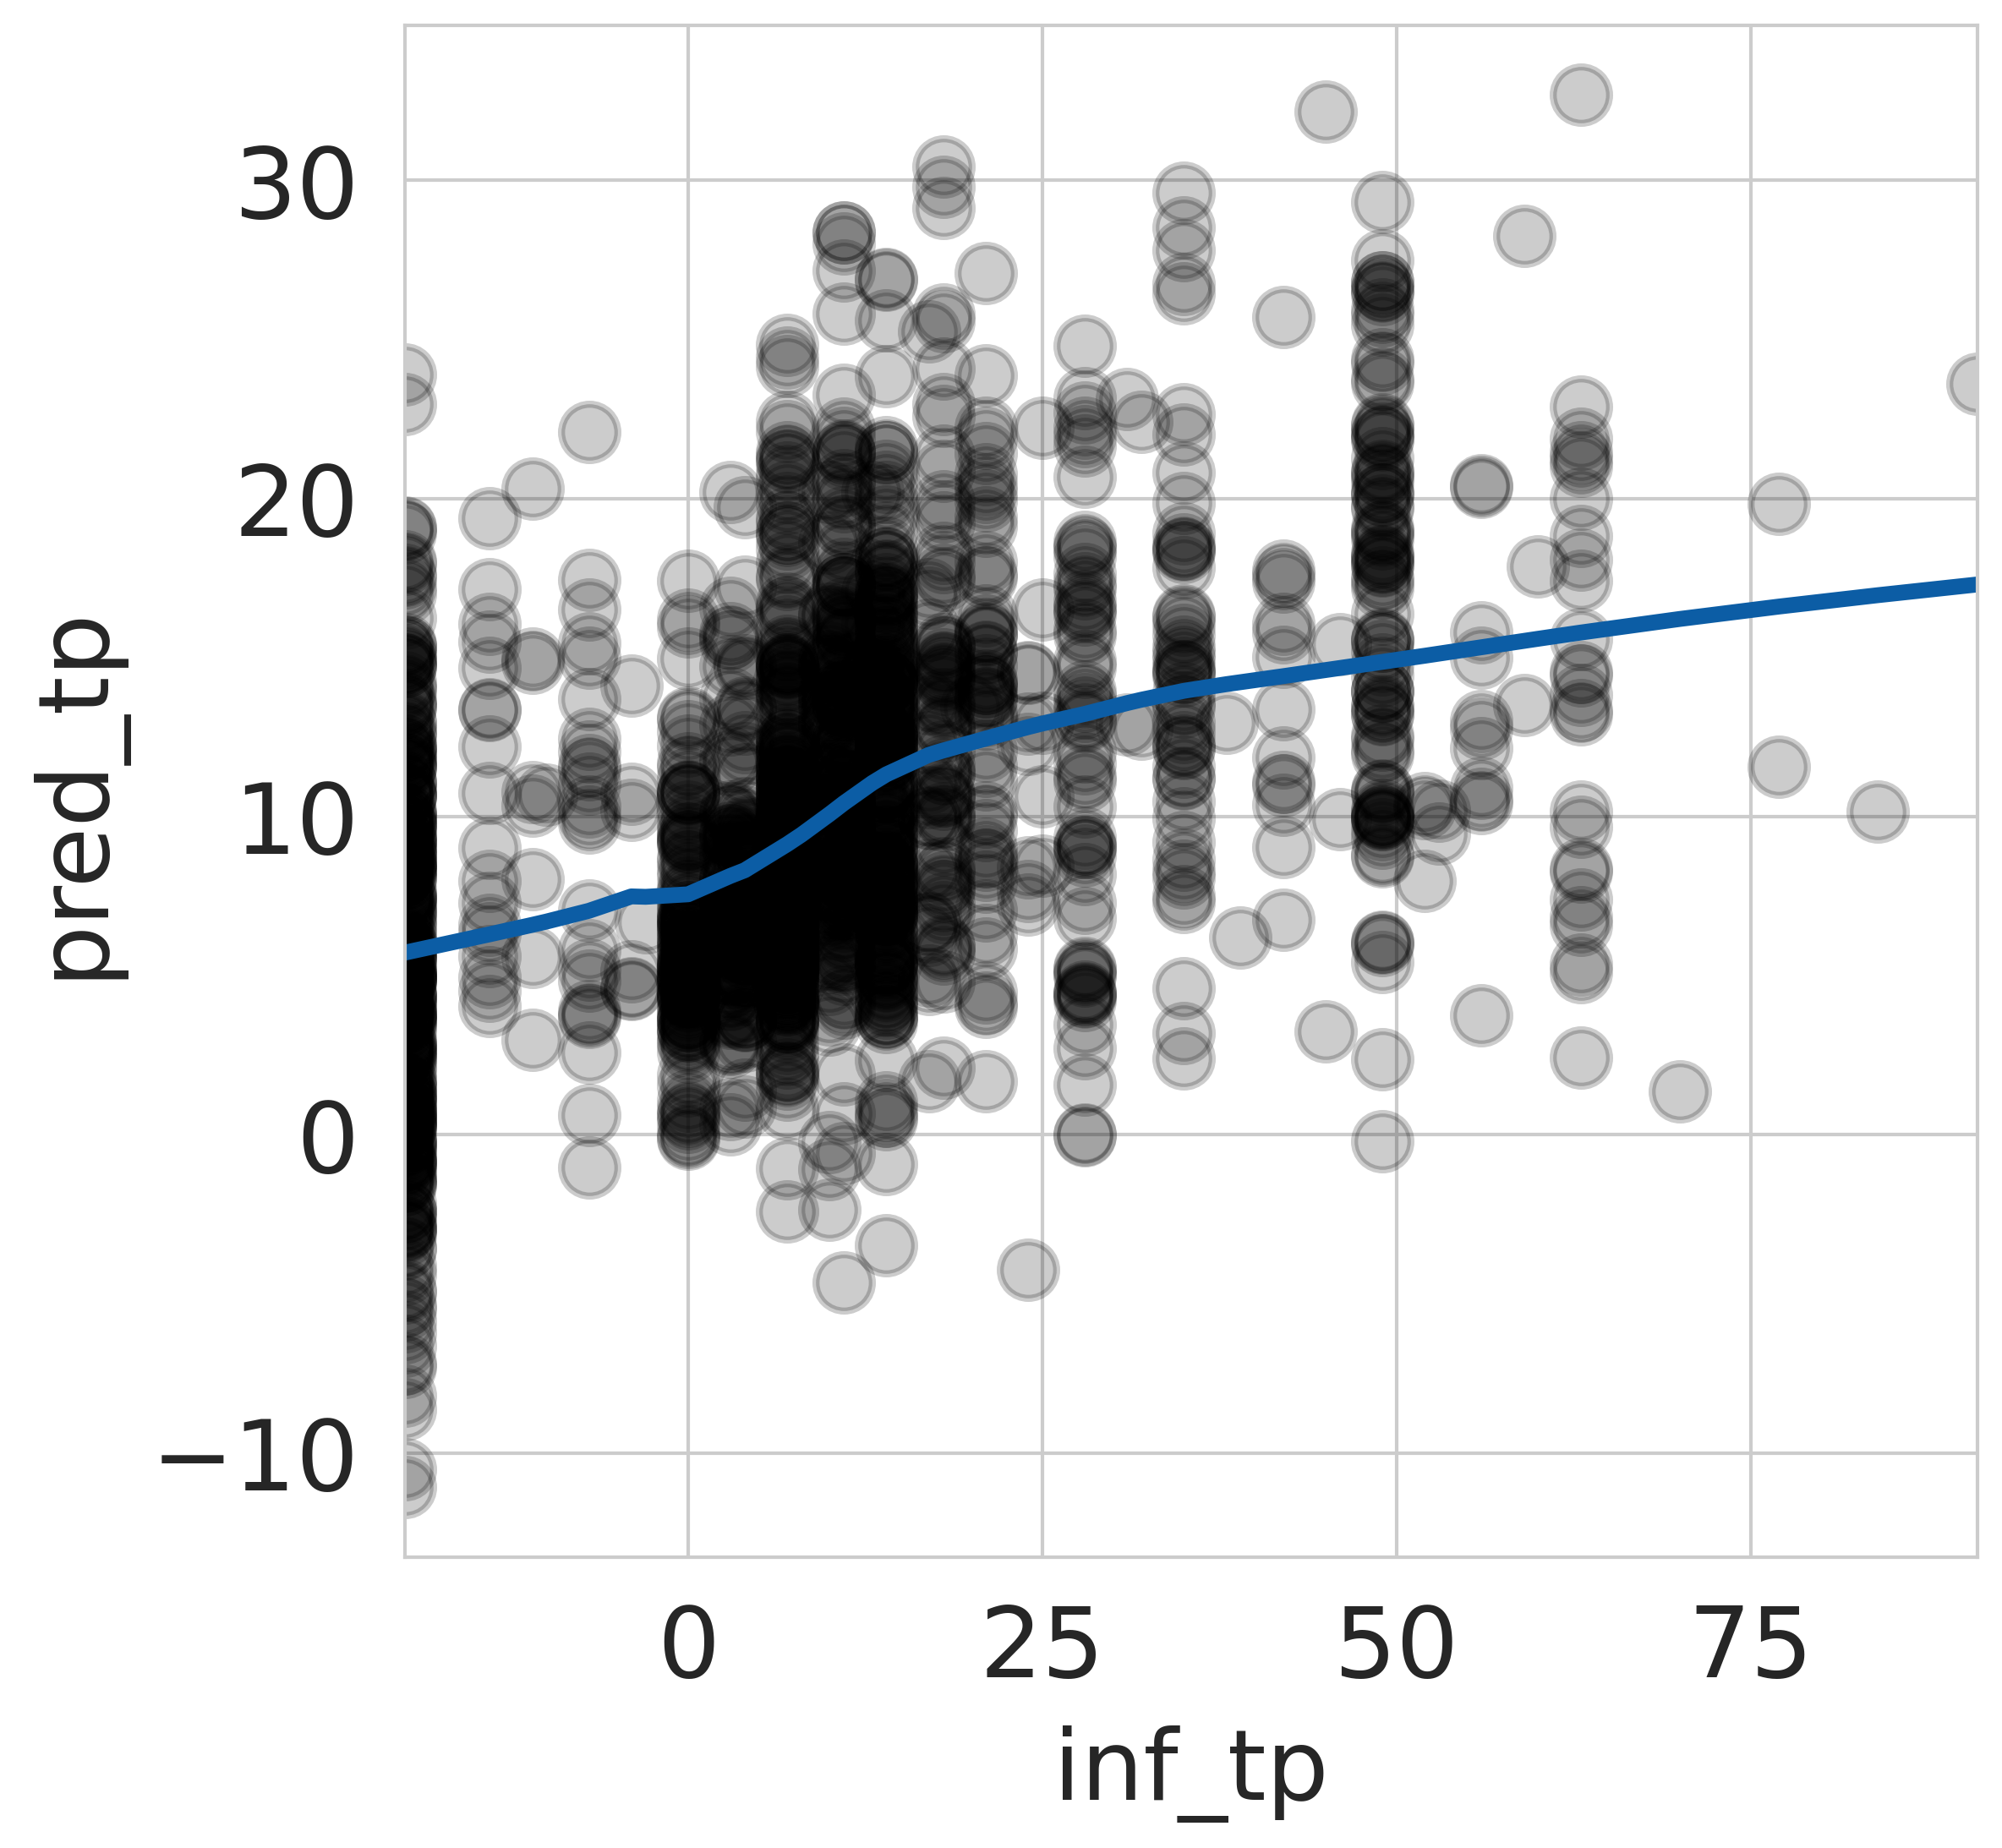

In [11]:
sig_txr_ri = [eid for eid in metaloader.data['RI'].stats_tests 
              if metaloader.data['RI'].stats_tests[eid].loc[
                  ['final@Pre', 'final@First', 'final@Mid', 'final@Post'],
                  #['final@Mid', 'final@Post'],
                  'qvals'].min() < 0.001]

inf_df, n_eids = make_data(sig_txr_ri, infect_df, as_type='RI')
pred_df, mods = train_loocv(inf_df, n_eids)

100%|██████████| 1244/1244 [10:28<00:00,  1.98it/s]


SpearmanrResult(correlation=0.4054726357331841, pvalue=4.487886427609621e-61)
(0.3813245574060946, 1.1751982376220693e-53)


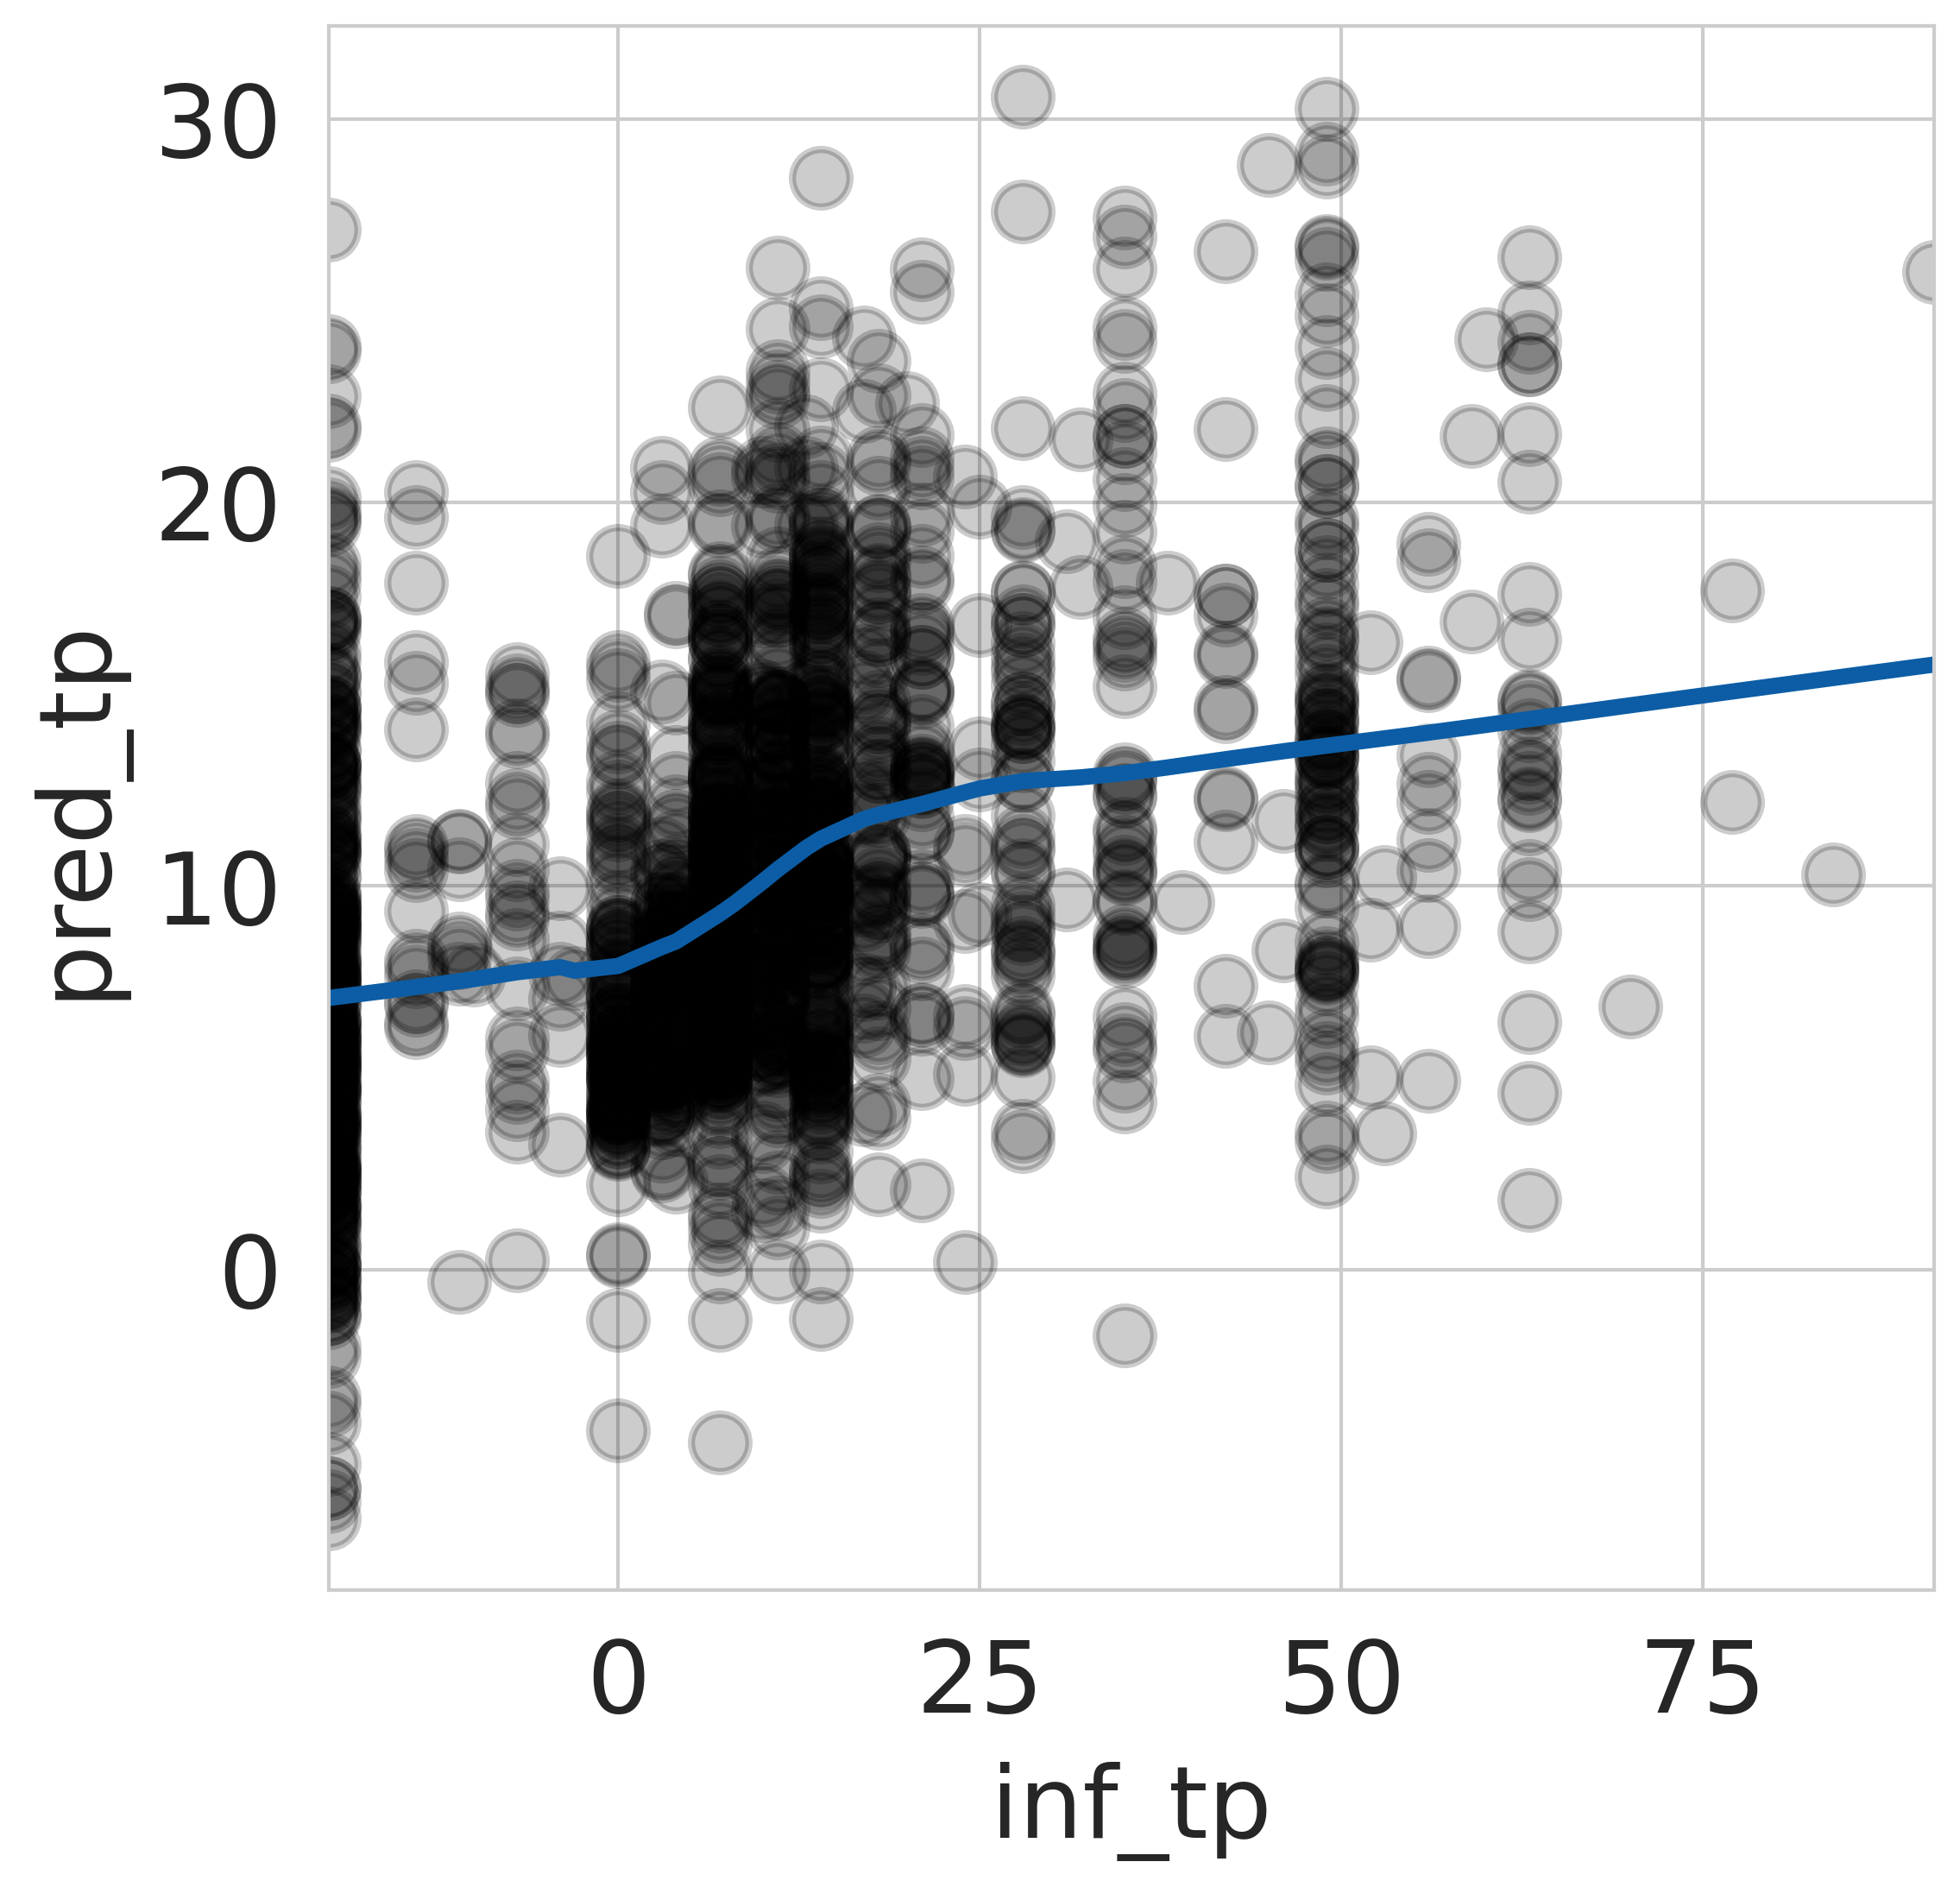

In [12]:
sig_txr_a5 = [eid for eid in metaloader.data['A5SS'].stats_tests 
              if metaloader.data['A5SS'].stats_tests[eid].loc[
                  ['final@Pre', 'final@First', 'final@Mid', 'final@Post'],
                  #['final@Mid', 'final@Post'],
                  'qvals'].min() < 0.001]

inf_df, n_eids = make_data(sig_txr_a5, infect_df, as_type='A5SS')
pred_df, mods = train_loocv(inf_df, n_eids)

100%|██████████| 1244/1244 [12:22<00:00,  1.68it/s]


SpearmanrResult(correlation=0.4314539156515083, pvalue=9.051311763404802e-70)
(0.40587085789378446, 3.3455972627930475e-61)


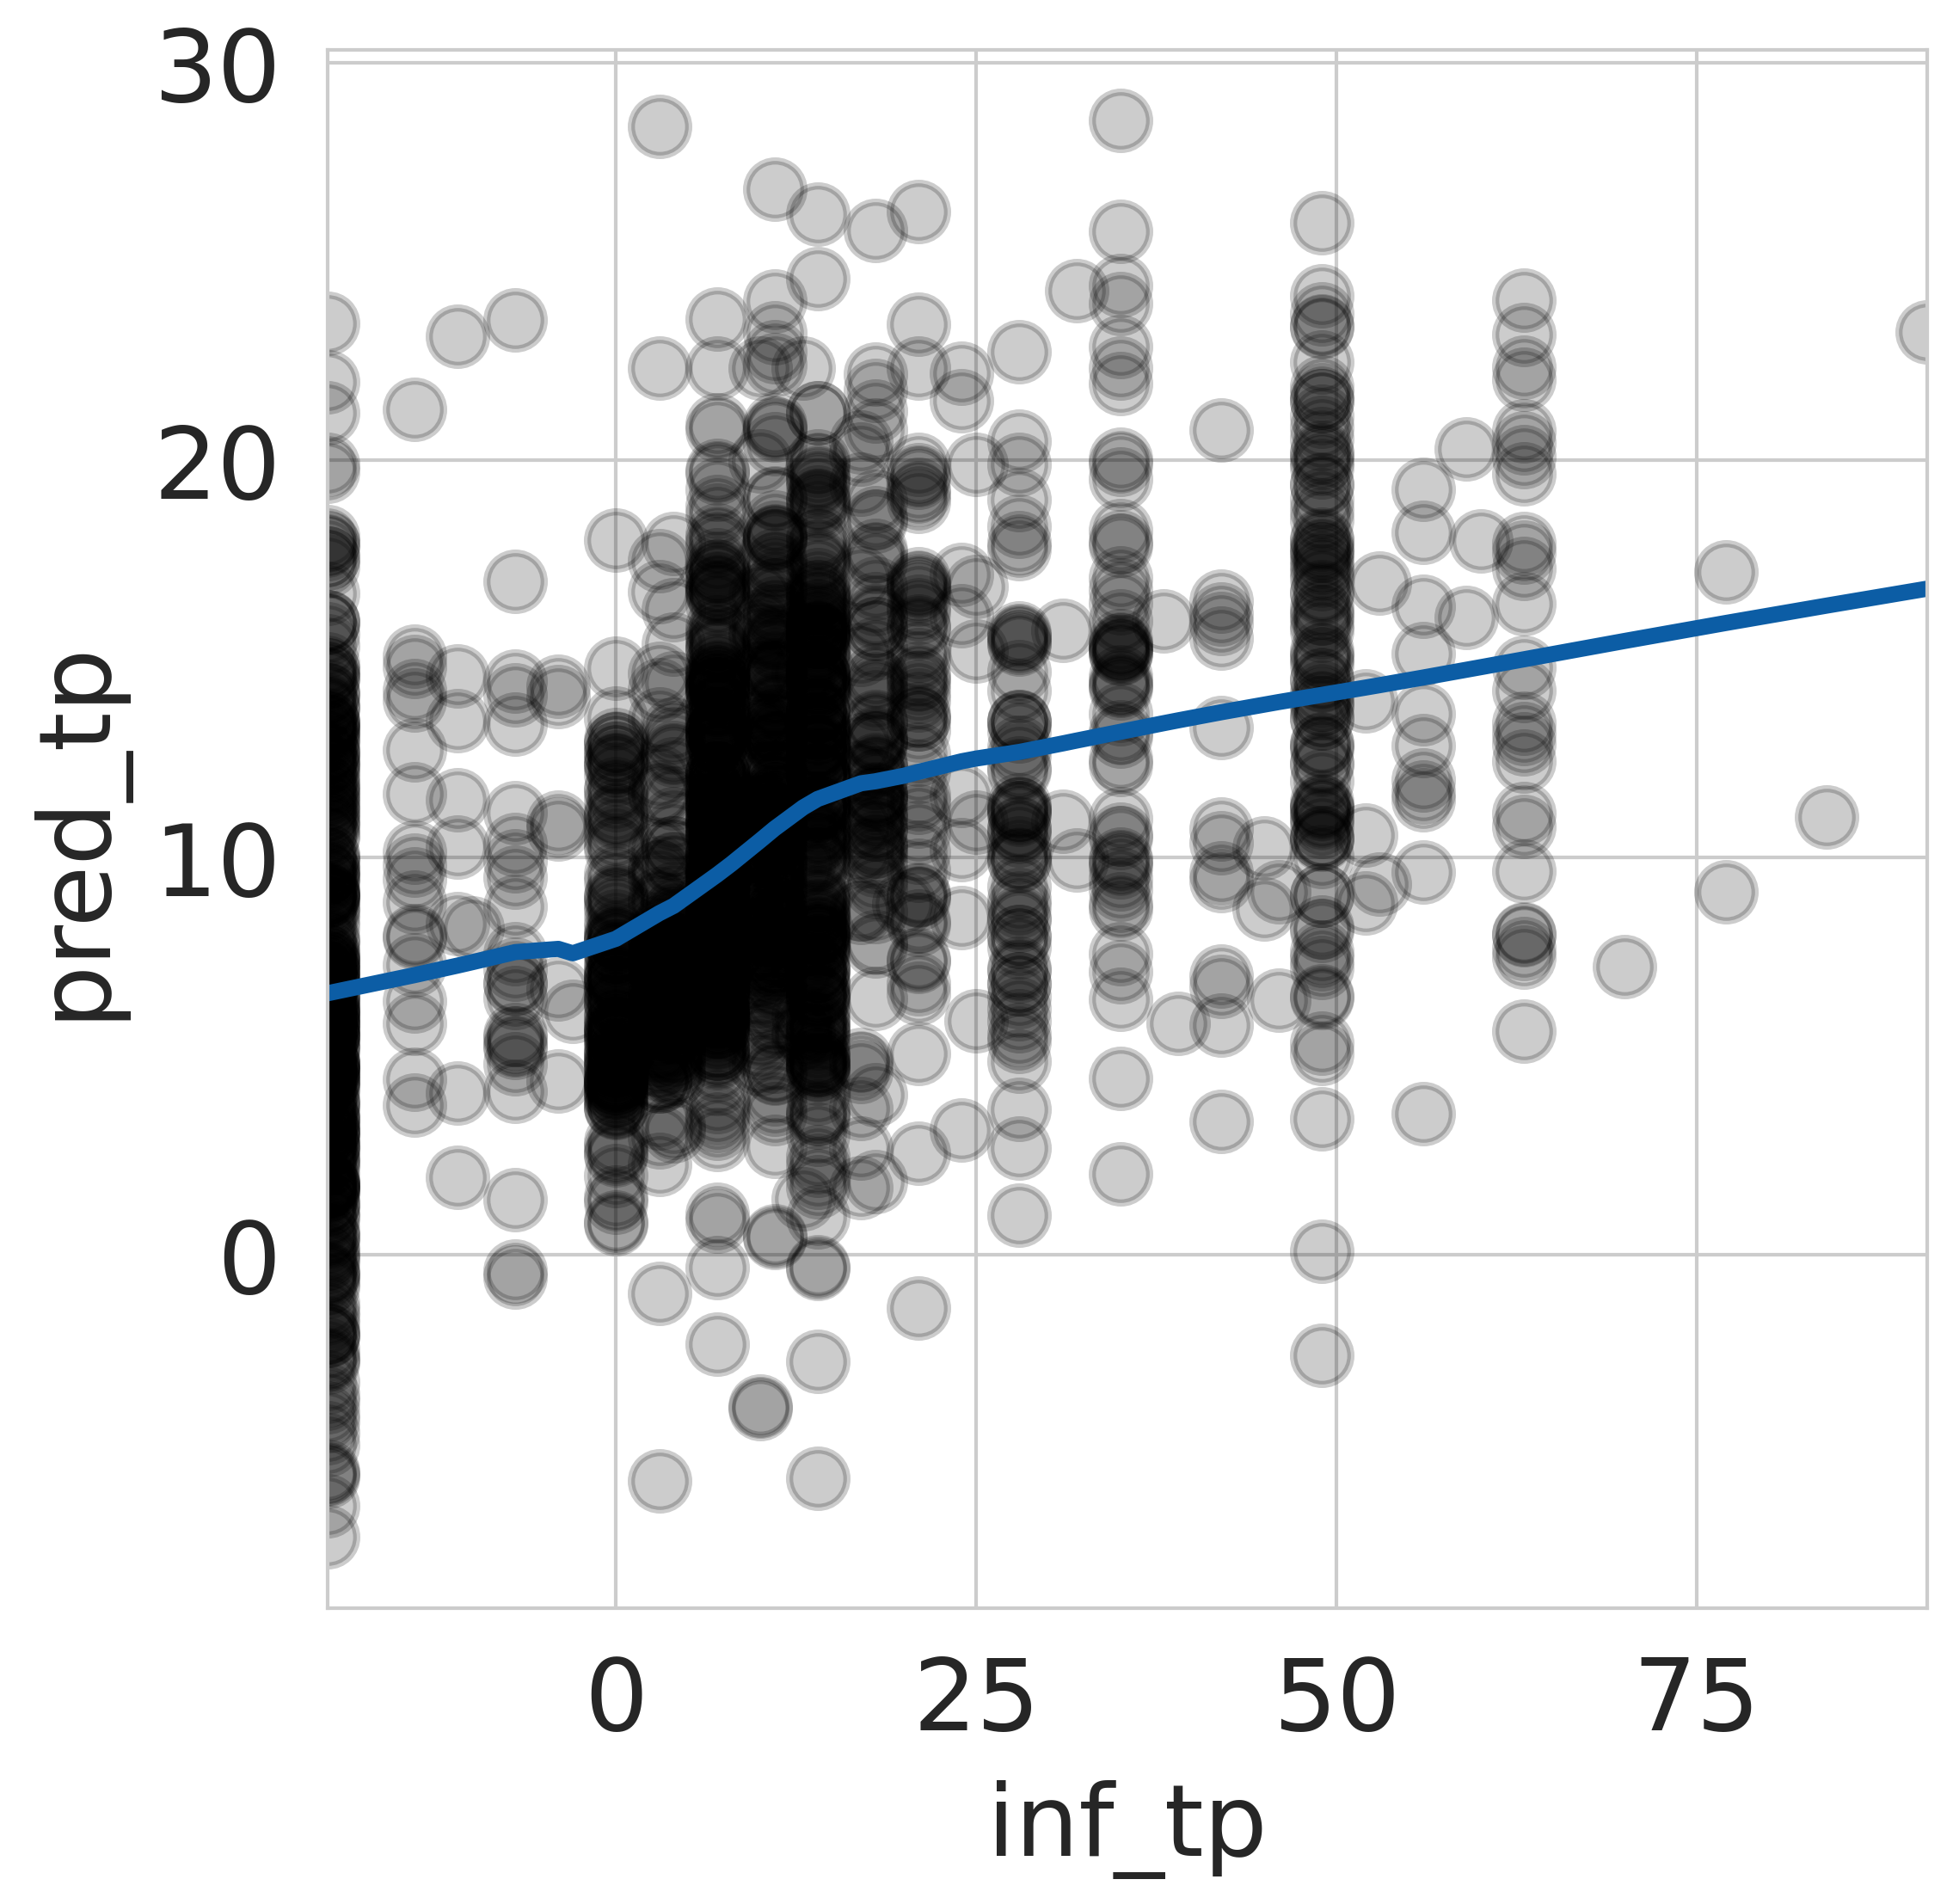

In [13]:
sig_txr_a3 = [eid for eid in metaloader.data['A3SS'].stats_tests 
              if metaloader.data['A3SS'].stats_tests[eid].loc[
                  ['final@Pre', 'final@First', 'final@Mid', 'final@Post'],
                  #['final@Mid', 'final@Post'],
                  'qvals'].min() < 0.001]

inf_df, n_eids = make_data(sig_txr_a3, infect_df, as_type='A3SS')
pred_df, mods = train_loocv(inf_df, n_eids)